In [272]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

## data prep
from sklearn.model_selection import train_test_split
import missingno as msno 

## modeling
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

## evaluation
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## visualization 
from plotnine import *
from plotly.offline import iplot
import plotly_express as px
import matplotlib.image as img
from matplotlib import pyplot as plt


## suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [273]:
df = pd.read_csv('../washington-post-election-night-model/data/county_data.csv')

In [274]:
## change fips to string
df['fips'] = df['fips'].astype(str)
df['fips'] = df['fips'].str.zfill(5)

In [275]:
## features we will mainly use
features = [
    #'fips',
    'female',
    'male',
    'white',
    'black',
    'aapi',
    'hispanic',
    'other_race_alone',
    'median_income',
    'bachelor_or_higher',
    'age_le_30',
    'age_ge_30_le_45',
    'age_ge_45_le_65',
    'age_ge_65',
    'total_votes_2016'
]

# Target variable

In [276]:
df['vote_change']=(df['total_votes_2020']-df['total_votes_2016'])

# Data Prep

##### Explore which counties are blank

In [277]:
df = df.dropna()

##### Train test split

In [278]:
X = df[features]
y = df['total_votes_2020']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
## relative to what we observed 
## normalizing interval by what we observed in voter turnout in 2020
## index or ratio
## bandwidth, quality factor , parameter 

# Functions

In [279]:
def calculate_error(df):
    """
    Calculate the absolute error associated with prediction intervals
    
    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe
    
    """
    ## calculate raw residuals between upper, midpoint, and lower intervals
    df['absolute_error_lower'] = (df['lower'] - df['total_votes_2020'])#.abs()
    df['absolute_error_upper'] = (df['upper'] - df['total_votes_2020'])#.abs()
    df['absolute_error_mid'] = (df['mid'] - df['total_votes_2020'])#.abs()
    
    ## calculate the average raw residuals
    df['absolute_error_average'] = (df['absolute_error_lower'] + df['absolute_error_upper'] + df['absolute_error_mid']) / 3
    
    ## check actual 2020 turnout was within guessed bounds
    df['in_bounds'] = df['total_votes_2020'].between(left=df['lower'], right=df['upper'])
    
    ## calculate percent errors/ normalized by total 2020 votes in each relative county
    df['percent_error_lower'] = (df['absolute_error_lower']/df['total_votes_2020'])*100
    df['percent_error_mid'] = (df['absolute_error_mid']/df['total_votes_2020'])*100
    df['percent_error_upper'] = (df['absolute_error_upper']/df['total_votes_2020'])*100
    df['percent_error_avg'] = (df['absolute_error_average']/df['total_votes_2020'])*100
    
    
    ## ratio on how big an interval was guessed, normalized by magnitude of county votes
    df['interval_ratio'] = (df['upper'] - df['lower'])/df['total_votes_2020']
    
  
    return df

In [280]:
def plot_interval_metrics(df):
    metrics_to_plot = df[[col for col in df if 'percent_error' in col]]

    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

    dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

    p = (ggplot(dat,aes(x="metric",y="Percent Error")) +
      geom_jitter(width = .25,alpha=.4,show_legend=False, color = "#a54f7e") +
      scale_y_log10() +
      labs(title="Error Metrics", x = "Metric")
        )
    
    return p
#, whis=np.inf

In [417]:
def plot_interval_metrics_seaborn(df, y, y_lim):
    fig, ax = plt.subplots(figsize=(7,5))
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    metrics_to_plot = df[[col for col in df if 'percent_error' in col]]
    
    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

    dat = metrics_to_plot.melt(var_name="Metric", value_name='Percent Error')
    dat['Percent Error'] =  pd.to_numeric(dat['Percent Error'])

    ax = sns.stripplot(x="Metric", y="Percent Error", data=dat,
                       jitter=0.3,
                       alpha = 0.3,
                       color = '#a54f7e',
                       linewidth=1,
                       edgecolor = '#a54f7e')
    
    #ax = sns.boxplot(x="Metric", y="Percent Error", data=dat, color=".8")
    
    plt.title('Error Metrics', fontsize=22)
    plt.ylim(y, y_lim)
    plt.xlabel('Metric', fontsize=22)
    plt.ylabel('Percent Error', fontsize=22)
    
    labels = (
        "Lower",
        "Mid",
        "Upper",
        "Avg"
        
    )
    
    ax.set_yticklabels(ax.get_yticks(), size=24)
    ax.set_xticklabels(labels, size=24)
    

      
    ## medians
    lower_med = round(df['percent_error_lower'].median(),2)
    mid_med = round(df['percent_error_mid'].median(),2)
    upper_med = round(df['percent_error_upper'].median(),2)
    avg_med = round(df['percent_error_avg'].median(),2)
      
    #plt.text(0,lower_med,f'{lower_med:.2f} \n (Median)'.format(lower_med))
    ax.text(0, lower_med, f'{lower_med:.2f}', ha='center', va='center', size = 20, color = "#383838")
    ax.text(0, lower_med-25, '(Median)', ha='center', va='center', size = 12, color = "#383838")
    
    ## 1
    ax.text(1, mid_med, f'{mid_med:.2f}', ha='center', va='center', size = 20, color = "#383838")
    ax.text(1, mid_med-25, '(Median)', ha='center', va='center', size = 12, color = "#383838")
    
    ## 2
    ax.text(2, upper_med, f'{upper_med:.2f}', ha='center', va='center', size = 20, color = "#383838")
    ax.text(2, upper_med-25, '(Median)', ha='center', va='center', size = 12, color = "#383838")
    
    ## 3
    ax.text(3, avg_med, f'{avg_med:.2f}', ha='center', va='center', size = 20, color = "#383838")
    ax.text(3, avg_med-25, '(Median)', ha='center', va='center', size = 12, color = "#383838")
    
    
    return plt



<module 'matplotlib.pyplot' from 'C:\\Users\\madel\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

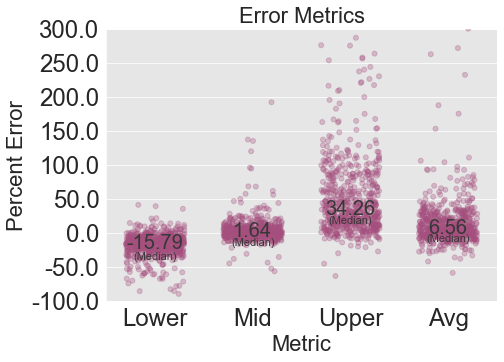

In [398]:
plot_interval_metrics_seaborn(gbrPredictions, -100,300)

In [204]:
def plot_interval_metrics_report(df):
    metrics_to_plot = df[[col for col in df if 'percent_error' in col]]

    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

    dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

    p = (ggplot(dat,aes(x="metric",y="Percent Error")) +
      geom_jitter(width = .25,alpha=.4,show_legend=False, color = "#a54f7e") +
      scale_y_log10() +
      labs(title="Error Metrics", x = "Metric") +
      theme(text = element_text(size=20)) +
      annotate(aes(x=1, label="test", y=.01), color="black") +
      geom_text(aes(x=2, label=round(df['percent_error_lower'].median(),2), y=.01), color="black") +
      geom_text(aes(x=3, label=round(df['percent_error_mid'].median(),2), y=.01), color="black") + 
      geom_text(aes(x=4, label=round(df['percent_error_upper'].median(),2), y=.01), color="black")
      
         
        )
      

    return p

In [141]:
def plot_interval_trends(df):
    #percent_in_bounds = df['in_bounds'].mean() * 100
    
    p = (ggplot(df, aes(x = "total_votes_2016", y="total_votes_2020")) +
     geom_point(size=1,alpha=.1,show_legend=False) + 
     geom_ribbon(aes(x="total_votes_2016", ymax="upper", ymin="lower"), fill="#a54f7e", alpha=.75) +
     scale_y_log10() +
     scale_x_log10() +
#     xlim(1000, 25000) +
#     ylim(1000, 25000) +
     labs(x = "Total Votes in 2016",
          y="Total Votes in 2020",color="",
          title="Prediction Interval") +
      theme(text = element_text(size=20)) 
    )
    return p


##### Evaluate how close the guesses are 

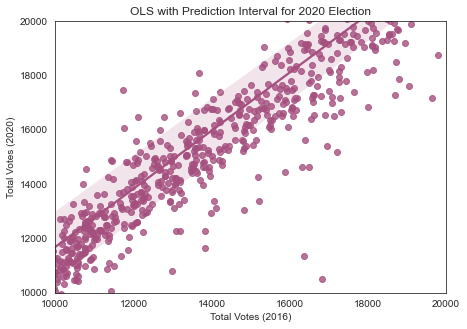

In [432]:
######### add lines to display evaluation
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("white")

fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(x='total_votes_2016', y='total_votes_2020', data=df, color = "#a54f7e").set_title('OLS with Prediction Interval for 2020 Election')
plt.xlim(10000, 20000)
plt.ylim(10000, 20000)
#fig.suptitle('Figure 4: Age Groups vs. Voting in 2020', fontsize=12, y=1.01)
#fig.suptitle
plt.xlabel("Total Votes (2016)")
plt.ylabel("Total Votes (2020)")

fig.savefig("../washington-post-election-night-model/figures/example.png", dpi = 300,  bbox_inches="tight")

In [14]:
reg = LinearRegression()
reg.fit(Xtrain, ytrain)

LinearRegression()

# Parametric, OLS

##### Generating prediction intervals and then counting counties in interval vs. out of interval.

We can calculate the percentage of the time the actual value is within the range, but this can be easily optimized by making the interval very wide. Therefore, we also want a metric that takes into account how far away the predictions are from the actual value, such as absolute error.


In the notebook, I’ve provided a function that calculates the absolute error for the lower, mid, and upper predictions and then averages the upper and lower error for an “Interval” absolute error. We can do this for each data point and then plot a boxplot of the errors (the percent in bounds is in the title):

https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

In [15]:
# Set lower and upper quantile
lower_alpha = 0.05
upper_alpha = 0.95

n_estimators = 100
max_depth = 5

# Each model has to be separate
lower_model = GradientBoostingRegressor(
    loss="quantile", alpha=lower_alpha, n_estimators=n_estimators, max_depth=max_depth
)
# The mid model will use the default
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=n_estimators, max_depth=max_depth)

upper_model = GradientBoostingRegressor(
    loss="quantile", alpha=upper_alpha, n_estimators=n_estimators, max_depth=max_depth
)

In [16]:
# modeling 
lower_model.fit(Xtrain, ytrain)
mid_model.fit(Xtrain, ytrain)
upper_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.95, loss='quantile', max_depth=5)

In [17]:
## get predictions 
gbrPredictions = pd.DataFrame(ytest)
gbrPredictions['total_votes_2016'] = df['total_votes_2016']
gbrPredictions['lower'] = lower_model.predict(Xtest)
gbrPredictions['mid'] = mid_model.predict(Xtest)
gbrPredictions['upper'] = upper_model.predict(Xtest)
#predictions.describe()

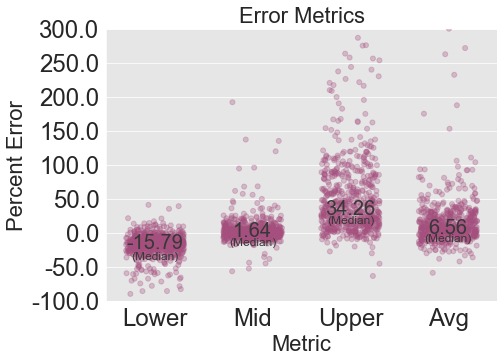

In [414]:
## calculate errors to be graphed
gbrPredictions = calculate_error(gbrPredictions)

## graph
#gbr_metrics = plot_interval_metrics_report(gbrPredictions)
gbr_trends = plot_interval_trends(gbrPredictions)

rfqr_metrics = plot_interval_metrics_seaborn(gbrPredictions,-100,300)
rfqr_metrics.savefig("../washington-post-election-night-model/figures/gbr_metrics1.png", dpi = 300,  bbox_inches="tight")

#gbr_metrics.save("../washington-post-election-night-model/figures/gbr_metrics.png", dpi=700, verbose=False)
gbr_trends.save("../washington-post-election-night-model/figures/gbr_trends.png", dpi=700, verbose=False)

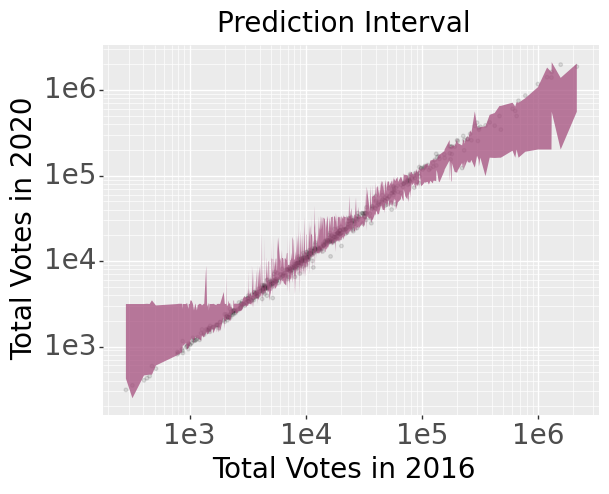

<ggplot: (107096448235)>

In [20]:
plot_interval_trends(gbrPredictions)

# Quantile Regression Visually

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [22]:
mod = smf.quantreg('total_votes_2020 ~ total_votes_2016 + \
    female + \
    male + \
    white + \
    black + \
    aapi + \
    hispanic + \
    other_race_alone + \
    median_income + \
    bachelor_or_higher + \
    age_le_30 + \
    age_ge_30_le_45 + \
    age_ge_45_le_65 + \
    age_ge_65', df)

In [23]:
quantiles = np.arange(.05, .96, .1)

def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['total_votes_2016']] + res.conf_int().loc['total_votes_2016'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('total_votes_2020 ~ total_votes_2016', df).fit()
ols_ci = ols.conf_int().loc['total_votes_2016'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['total_votes_2016'],
           lb = ols_ci[0],
           ub = ols_ci[1])

#print(models)
#print(ols)

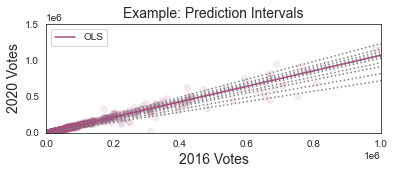

In [436]:
x = np.arange(df.total_votes_2016.min(), df.total_votes_2016.max(), 50)

sns.set_style("white")

get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(6, 2))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='#a54f7e', label='OLS')
ax.scatter(df.total_votes_2016, df.total_votes_2020, alpha=.1, color = '#a54f7e')
plt.xlim(10000, 20000)
ax.set_xlim((0, 1000000))
ax.set_ylim((0, 1500000))
legend = ax.legend()
ax.set_xlabel('2016 Votes', fontsize=14)
ax.set_ylabel('2020 Votes', fontsize=14)
ax.set_title('Example: Prediction Intervals', fontsize=14)

fig.savefig("../washington-post-election-night-model/figures/prediction_interval_ex.png", dpi = 300,  bbox_inches="tight")

# random forest quantile regression 

In [25]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston
from skgarden import RandomForestQuantileRegressor


from nonconformist.base import RegressorAdapter
from nonconformist.icp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc, RegressorNormalizer

In [26]:
## modeling
rfqr = RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=1000)
rfqr.fit(Xtrain, ytrain)

RandomForestQuantileRegressor(min_samples_split=10, n_estimators=1000,
                              random_state=0)

In [27]:
## get predictions 
rfqrPredictions = pd.DataFrame(ytest)
rfqrPredictions['total_votes_2016'] = df['total_votes_2016']
rfqrPredictions['lower'] = rfqr.predict(Xtest, quantile= 5)
rfqrPredictions['mid'] = rfqr.predict(Xtest, quantile = 50)
rfqrPredictions['upper'] = rfqr.predict(Xtest, quantile= 95)
#rfqrPredictions.tail()

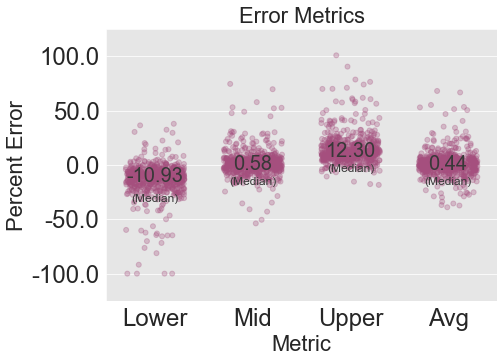

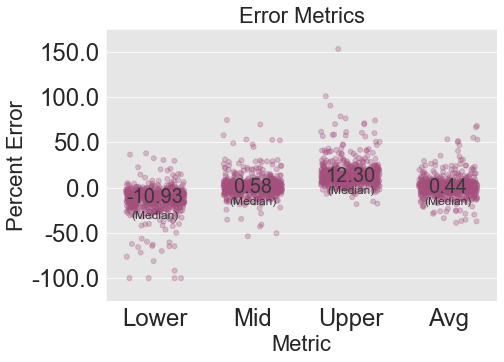

In [415]:
## plot
rfqrPredictions = calculate_error(rfqrPredictions)


rfqr_metrics = plot_interval_metrics_seaborn(rfqrPredictions,-125,125)
rfqr_trends = plot_interval_trends(rfqrPredictions)


rfqr_metrics = plot_interval_metrics_seaborn(rfqrPredictions,-125,175)
rfqr_metrics.savefig("../washington-post-election-night-model/figures/rfqr_metrics1.png", dpi = 300,  bbox_inches="tight")
#rfqr_metrics.save("../washington-post-election-night-model/figures/rfqr_metrics.png", dpi=700, verbose=False)
rfqr_trends.save("../washington-post-election-night-model/figures/rfqr_trends.png", dpi=700, verbose=False)

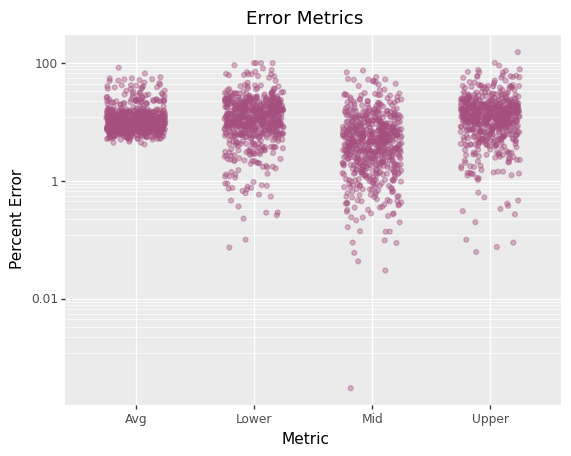

<ggplot: (106982153346)>

In [29]:
plot_interval_metrics(rfqrPredictions)

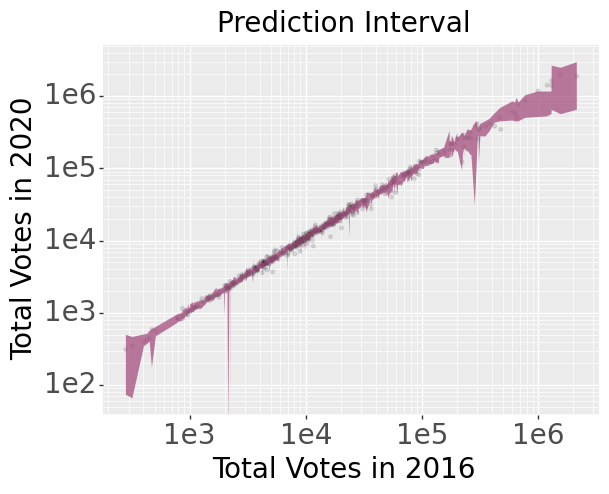

<ggplot: (106982195125)>

In [30]:
## plot 
plot_interval_trends(rfqrPredictions)

# Conformalized quantile regression

In [ ]:
# Conformal Wrapper 
#https://github.com/donlnz/nonconformist/blob/master/examples/icp_regression_tree.py

# my version of conformalized quantile regression (taylor's version)

In [31]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston

from nonconformist.base import RegressorAdapter
from nonconformist.icp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc, RegressorNormalizer


##### further split for calibration that model requires

In [32]:
## split X train into two equal groups for training and calibrating
Xtrain_nc, Xcal_nc, ytrain_nc, ycal_nc = train_test_split(Xtrain, ytrain, test_size=0.5, random_state=1)

In [33]:
Xtrain_nc = Xtrain_nc.to_numpy()
ytrain_nc = ytrain_nc.to_numpy()

Xcal_nc = Xcal_nc.to_numpy()
ycal_nc = ycal_nc.to_numpy()

Xtest_nc = Xtest.to_numpy()
ytest_nc = ytest.to_numpy()

##### without nornalization

In [34]:
## train and calibrate
underlying_model = RegressorAdapter(DecisionTreeRegressor(min_samples_leaf=5))
## RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=1000)


## Nonconformity scorer using an underlying regression model
nc = RegressorNc(underlying_model, AbsErrorErrFunc())

## Nonconformity scorer object used to calculate nonconformity of calibration examples and test patterns
## Inductive conformal classifier
icp = IcpRegressor(nc)
icp.fit(Xtrain_nc, ytrain_nc)
icp.calibrate(Xcal_nc, ycal_nc)

to avoid a redindexing hassle convert array back to dataframe and getting in the same order as before we split for train and calibrate, I'm just pulling directly from the array for the column I'll neeed (2016 election returns)


In [35]:
Xtest_df = pd.DataFrame(Xtest_nc)

In [36]:
## predict

prediction = icp.predict(Xtest_nc, significance=0.1)
header = ['lower','upper','total_votes_2020','size']
size = prediction[:, 1] - prediction[:, 0]
table = np.vstack([prediction.T, ytest_nc, size.T]).T
cqrPredictions = pd.DataFrame(table, columns=header)

cqrPredictions['total_votes_2016'] = Xtest_df[13]
cqrPredictions['mid'] = (cqrPredictions['size']/2) + cqrPredictions['lower']

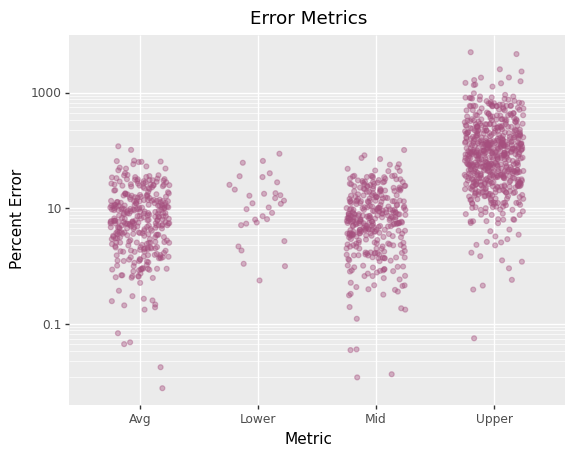

<ggplot: (106974461766)>

In [336]:
cqrPredictions = calculate_error(cqrPredictions)

plot_interval_metrics(cqrPredictions)

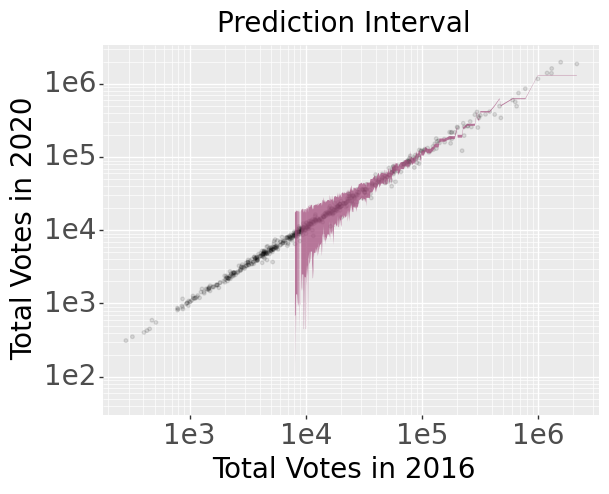

<ggplot: (106982330772)>

In [38]:
plot_interval_trends(cqrPredictions)

##### with nornalization

In [425]:
##train and calibrate
underlying_model = RegressorAdapter(RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=1000))
normalizing_model = RegressorAdapter(KNeighborsRegressor(n_neighbors=1))
normalizer = RegressorNormalizer(underlying_model, normalizing_model, AbsErrorErrFunc())


nc = RegressorNc(underlying_model, AbsErrorErrFunc(), normalizer)
icp = IcpRegressor(nc)
icp.fit(Xtrain_nc, ytrain_nc)
icp.calibrate(Xcal_nc, ycal_nc)

In [426]:
##predict
prediction = icp.predict(Xtest_nc, significance=0.1)
header = ['lower','upper','total_votes_2020','size']
size = prediction[:, 1] - prediction[:, 0]
table = np.vstack([prediction.T, ytest_nc, size.T]).T
cqrnPredictions = pd.DataFrame(table, columns=header)


## create predictions df
cqrnPredictions['total_votes_2016'] = Xtest_df[13]
cqrnPredictions['mid'] = (cqrPredictions['size']/2) + cqrPredictions['lower']

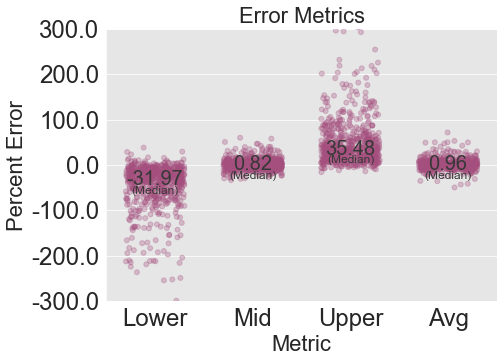

In [428]:
cqrnPredictions = calculate_error(cqrnPredictions)


#cqrn_metrics = plot_interval_metrics_report(cqrnPredictions)
cqrn_trends = plot_interval_trends(cqrnPredictions)


cqr_metrics = plot_interval_metrics_seaborn(cqrnPredictions,-300,300)
#cqr_metrics.savefig("../washington-post-election-night-model/figures/cqr_metrics1.png", dpi = 300,  bbox_inches="tight")

#cqrn_metrics.save("../washington-post-election-night-model/figures/cqr_metrics.png", dpi=500, verbose=False)
#cqrn_trends.save("../washington-post-election-night-model/figures/cqr_trends.png", dpi=500, verbose=False)

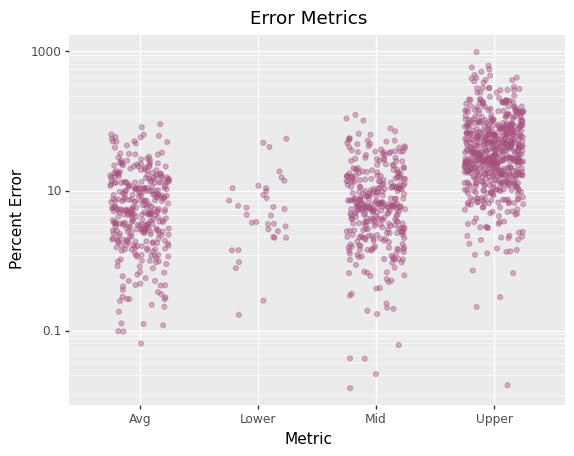

<ggplot: (107003065239)>

In [429]:
plot_interval_metrics(cqrnPredictions)

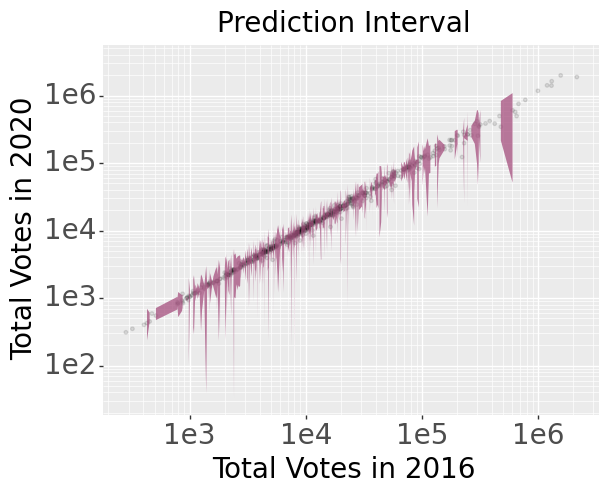

<ggplot: (106995164657)>

In [430]:
plot_interval_trends(cqrnPredictions)

# Overall/ comparison

In [46]:
## add columns to predict to indicate type of model
gbrPredictions['model'] = 'gbr'
rfqrPredictions['model'] = 'rfqr'
#cqrPredictions['model'] = 'cqr'
cqrnPredictions['model'] = 'cqr'

In [420]:
frames = [gbrPredictions, rfqrPredictions, cqrnPredictions]
predictions = pd.concat(frames)

## percent error

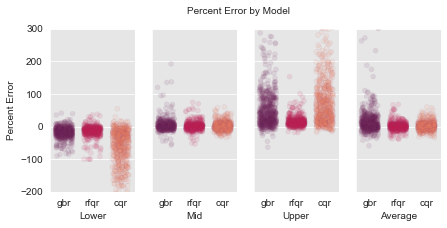

In [423]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize = (7,3))
#sns.regplot(x=idx, y=df['x'], ax=ax1)
#sns.regplot(x=idx, y=df['y'], ax=ax2)

sns.stripplot(x="model", y="percent_error_lower",
                   data=predictions, jitter=0.3,
                   alpha = 0.1,
                   color = '#a54f7e',
                   linewidth=0.5,
                   edgecolor = '#a54f7e',
                   palette="rocket",
                   ax= ax1)

sns.stripplot(x="model", y="percent_error_mid",
                   data=predictions, jitter=0.3,
                   alpha = 0.1,
                   color = '#a54f7e',
                   linewidth=0.5,
                   edgecolor = '#a54f7e',
                   palette="rocket",
                   ax= ax2)



sns.stripplot(x="model", y="percent_error_upper",
                   data=predictions, jitter=0.3,
                   alpha = 0.1,
                   color = '#a54f7e',
                   linewidth=0.5,
                   edgecolor = '#a54f7e',
                   palette="rocket",
                   ax= ax3)



sns.stripplot(x="model", y="percent_error_avg",
                   data=predictions, jitter=0.3,
                   alpha = 0.1,
                   color = '#a54f7e',
                   linewidth=0.5,
                   edgecolor = '#a54f7e',
                   palette="rocket",
                   ax= ax4)

## remove y labels
ax1.set_ylabel("Percent Error")
ax2.set_ylabel(None)
ax3.set_ylabel(None)
ax4.set_ylabel(None)

## remove x
ax1.set_xlabel("Lower")
ax2.set_xlabel("Mid")
ax3.set_xlabel("Upper")
ax4.set_xlabel("Average")


ax1.set_ylim(-200, 300)
#plt.title('Lower')
plt.suptitle('Percent Error by Model', fontsize = 10)


fig.savefig("../washington-post-election-night-model/figures/comparison_percent.png", dpi = 300,  bbox_inches="tight")

## In-Bound Percentage

In [92]:
def plot_inbound_trends_report(df):
    percent_in_bounds = df['in_bounds'].mean() * 100

    df_ib = df[df['in_bounds'] == True]
    df_oob = df[df['in_bounds'] == False]


    p= (ggplot()
     # Range strip
     + geom_jitter(
         df_ib,
         aes(x = "total_votes_2016", y="total_votes_2020"),
         size=3,
         alpha=.25,
         width = .3,
         color='#a7a9ac'
     )
     # Age group markers
     + geom_jitter(
         df_oob,
         aes(x="total_votes_2016",y="total_votes_2020"),
         alpha=.75,
         size=3,
         width = .5,
         color = '#a54f7e'
     )
     + scale_y_log10() 
     + scale_x_log10()
     + labs(x = "Total Votes in 2016",
              y="Total Votes in 2020", color="",
              title=f"In Bounds = {percent_in_bounds:.2f}%") 
    + theme(text = element_text(size=22))
    )
        
    return p

In [60]:
def plot_inbound_trends(df):
    percent_in_bounds = df['in_bounds'].mean() * 100

    df_ib = df[df['in_bounds'] == True]
    df_oob = df[df['in_bounds'] == False]


    p= (ggplot()
     # Range strip
     + geom_jitter(
         df_ib,
         aes(x = "total_votes_2016", y="total_votes_2020"),
         size=3,
         alpha=.25,
         width = .3,
         color='#a7a9ac'
     )
     # Age group markers
     + geom_jitter(
         df_oob,
         aes(x="total_votes_2016",y="total_votes_2020"),
         alpha=.75,
         size=3,
         width = .5,
         color = '#a54f7e'
     )
     + scale_y_log10() 
     + scale_x_log10()
     + labs(x = "Total Votes in 2016",
              y="Total Votes in 2020", color="",
              title=f"In Bounds = {percent_in_bounds:.2f}%") 
    #+ theme(text = element_text(size=26))
    )
        
    return p

In [93]:
p = plot_inbound_trends_report(gbrPredictions)
p.save("../washington-post-election-night-model/figures/gbr_in_bounds.png", dpi=500, verbose=False)

p = plot_inbound_trends_report(rfqrPredictions)
p.save("../washington-post-election-night-model/figures/rfqr_in_bounds.png", dpi=500, verbose=False)

p = plot_inbound_trends_report(cqrnPredictions)
p.save("../washington-post-election-night-model/figures/cqr_in_bounds.png", dpi=500, verbose=False)

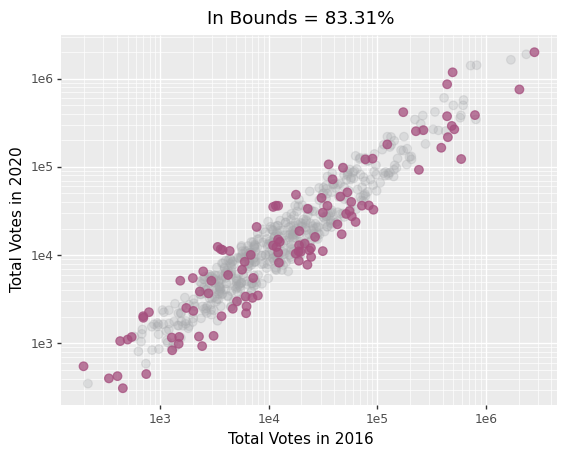

<ggplot: (106982281677)>

In [62]:
plot_inbound_trends(gbrPredictions)

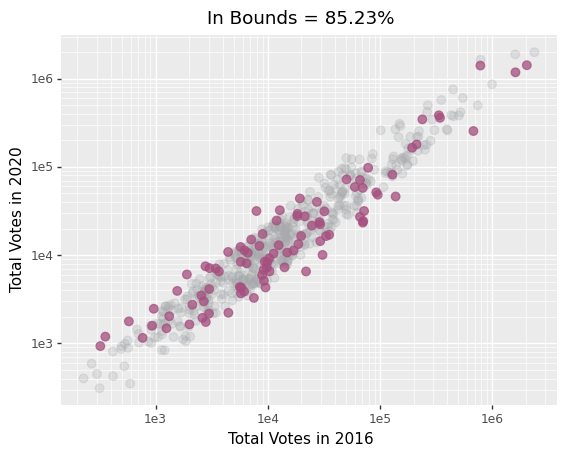

<ggplot: (107096636962)>

In [63]:
plot_inbound_trends(rfqrPredictions)

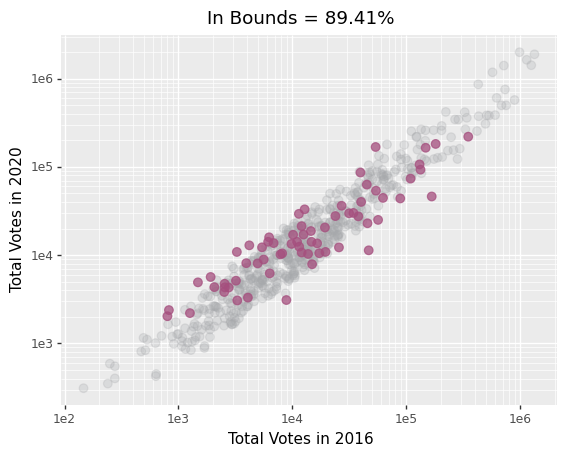

<ggplot: (107096636573)>

In [64]:
plot_inbound_trends(cqrnPredictions)

## relative interval

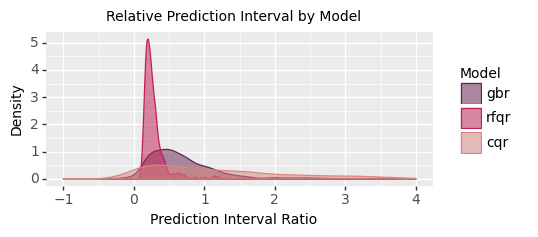

<ggplot: (107096469200)>

In [424]:
#sns.displot(predictions, x="interval_ratio", hue="model", kind="kde")

colors = {'cqr':'#d68780', 'gbr':'#662053', 'rfqr': '#c01d50'}  
predictions1 = predictions.assign(Model = pd.Categorical(predictions['model'], ordered=True, categories=['gbr', 'rfqr', 'cqr']))



p = (
    ggplot(predictions1, aes(x='interval_ratio', color='Model', fill='Model')) +
    geom_density(alpha=0.5) +
    xlim(-1,4) +
    scale_color_manual(values = colors) +
    scale_fill_manual( values = colors) + 
    theme(figure_size = (5, 2), text = element_text(size=10)) + 
    labs(x = "Prediction Interval Ratio",
              y="Density", 
              title="Relative Prediction Interval by Model") 
    
)




#p.save("../washington-post-election-night-model/figures/interval_ratio.png", dpi=500, verbose=False)

p

# graveyard

In [ ]:
gbrPredictions['model'] = 'gbr'
rfqrPredictions['model'] = 'rfqr'
cqrPredictions['model'] = 'cqr'
cqrnPredictions['model'] = 'cqrn'

# K means clustering

In [ ]:
from sklearn.cluster import KMeans

X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)


print(kmeans.labels_)
print(kmeans.predict([[0, 0], [12, 3]]))
print(kmeans.cluster_centers_)

In [ ]:
## rename X test
test = Xtest
## add y test back in
test['total_votes_2020'] = ytest

## merge test data with corresponding demographics data
cqrnError = pd.merge(cqrnPredictions, test, on=["total_votes_2016", "total_votes_2020"])


In [ ]:
X_cqrnError = cqrnError[features]
y_cqrnError = cqrnError['interval_ratio']

Xtrain_cqrnError, Xtest_cqrnError, ytrain_cqrnError, ytest_cqrnError = train_test_split(X_cqrnError, y_cqrnError, test_size=0.2, random_state=1)

In [ ]:
## visualizations
# https://www.r-bloggers.com/2019/07/measuring-feature-importance-in-k-means-clustering-and-variants-thereof/

## k means parameter tuning
# https://realpython.com/k-means-clustering-python/

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(Xtrain_cqrnError, Xtest_cqrnError)
lol = Xtest_cqrnError
lol['label'] = kmeans.predict(Xtest_cqrnError)



In [ ]:
lol[lol['label'] == 2]

In [ ]:
(ggplot(haha, aes(x = "total_votes_2016", y="total_votes_2020", color = "label")) +
     geom_point(size=1,alpha=.5,show_legend=False))

In [ ]:
df['NAME']

In [ ]:
### add county and fips

lol

haha = pd.merge(lol,df[['NAME', 'total_votes_2016', 'female', 'median_income', 'total_votes_2020']], on=['total_votes_2016', 'female', 'median_income'])


In [ ]:
haha[haha['label'] == 2]

In [ ]:
## Values

## 1) percent_error_mid
## 2) interval size/ population
## 3) in bounds classification

## K means cluster on value

## determine ideal number of clusters

## label clusters

## classify clusters

## model importance

## what is the downside of comparing MSE for all models?
## entire analysis has an argument
## systematic relationship in residuals
this is a model that makes certain kinds of mistakes for certains kinds of counties 
what is a way of examining a distribution of errors of knn that makes sense to me
KNN furthest outside mean error going to look at those observations
these counties that are really poorly classified, going to take the top 10 highest error counties >. demographicaly similaries 
knn > kmeans (clustering
             random centroid and nearest points and you repeat that processs until minimized distance)
parametric analysis of errors on non paramatirc does not work
flexible model and applied inflexible way of examining error distribution
knn has different has no pbjective function

# knn

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(Xtrain, ytrain)

In [ ]:
# split the data into a train and validation sets 

# base_model can be any regression 
#modelbase_mode.fit(X1, y1) 
base_prediction = knn.predict(Xtest) 

#compute the RMSE value 
## scikit RSME
error = mean_squared_error(base_prediction, ytest) ** 0.5 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest) 
st_dev = error

In [ ]:
error_model = LinearRegression()

In [ ]:
# split the data in train a validation set
#X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5)

# base_model can be any regression model 
knn.fit(Xtrain, ytrain) 
base_prediction = knn.predict(Xtest) 

# compute the prediction error vector on the validation set 
validation_error = (base_prediction - ytest) ** 2 
error_model.fit(Xtest, validation_error) 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest)
error = error_model.predict(Xtest)

https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

In [ ]:
knnPredictions = pd.DataFrame(ytest)
knnPredictions['total_votes_2016'] = df['total_votes_2016']
knnPredictions['std'] = error
knnPredictions['std'] = knnPredictions['std'].abs()**0.5

from scipy.stats import t

## sample size
N = len(knnPredictions)

## degrees of freedom
df = 2*N - 2

t = t.ppf(0.95, df)

knnPredictions['mid'] = knn.predict(Xtest)
knnPredictions['lower'] = knnPredictions['mid'] - (knnPredictions['std']*t)
knnPredictions['upper'] = knnPredictions['mid'] + (knnPredictions['std']*t)

#assert (predictions['upper'] > predictions['lower']).all()

knnPredictions.tail()

knnPredictions = calculate_error(knnPredictions)

plot_interval_metrics(knnPredictions)

plot_interval_trends(knnPredictions)

https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3

In [ ]:
metrics_to_plot = predictions[[col for col in predictions if 'percent_error' in col]]
metrics_to_plot['model'] = predictions['model']

# Rename the columns
metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

dat = metrics_to_plot.melt(id_vars=['Model'],var_name="metric", value_name='Percent Error')

p = (ggplot(dat,aes(x="metric",
                    y="Percent Error",
                    color = "Model")) +
    geom_jitter(width = .25,alpha=.4,show_legend=False) +
    scale_y_log10() +
    labs(title=f"Error Metrics"))

p

save(filename=None, format=None, path=None, width=None, height=None, units='in', dpi=None, limitsize=True, verbose=True, **kwargs)

In [ ]:
def plot_inbound_trends(df):
    percent_in_bounds = df['in_bounds'].mean() * 100
    
    #colors = {True:'red', False:'blue'}
    

    
    f, ax = plt.subplots(figsize=(7, 7))
    ax.set(xscale="log", yscale="log")
    #sns.regplot("x", "y", data, ax=ax, scatter_kws={"s": 100})
    
    sns.scatterplot(x = df.total_votes_2016,
                    y = df.total_votes_2016,
                    hue = df.in_bounds,
                   y_jitter = 'full',
                   x_jitter = "full")
    
    
    
    